In [6]:
import os

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import glob
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint# early stopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model # basic class for specifying and training a neural network

# Classifying teeth to M, P, I, C

In [2]:
mnist_model = tf.keras.models.load_model('/home/riikoro/thesis/code/pretrained_base_models/bangla_english_handwritten_mnist.keras')

In [4]:
tooth_labels = pd.read_csv('/home/riikoro/thesis/code/mnist-proof-of-concept/teeth/labels.csv')
type_labels = tooth_labels.iloc[:,:4]
type_labels

,m,p,c,i
0,1,0,0,0
1,0,0,0,1
2,0,1,0,0
3,1,0,0,0
4,0,1,0,0
5,0,0,0,1
6,0,0,0,1
7,1,0,0,0
8,0,0,1,0
9,0,1,0,0


In [9]:
for layer in mnist_model.layers:
    layer.trainable = False

new_output = Dense(4, activation='softmax')(mnist_model.layers[-2].output)
new_model = Model(mnist_model.input, new_output)
new_model.layers

[<InputLayer name=input_layer_4, built=True>,
 <Conv2D name=conv2d_16, built=True>,
 <Conv2D name=conv2d_17, built=True>,
 <MaxPooling2D name=max_pooling2d_8, built=True>,
 <Dropout name=dropout_12, built=True>,
 <Conv2D name=conv2d_18, built=True>,
 <Conv2D name=conv2d_19, built=True>,
 <MaxPooling2D name=max_pooling2d_9, built=True>,
 <Dropout name=dropout_13, built=True>,
 <Flatten name=flatten_4, built=True>,
 <Dense name=dense_8, built=True>,
 <Dropout name=dropout_14, built=True>,
 <Dense name=dense_1, built=True>]

In [10]:
for layer in new_model.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
True


In [14]:
def preprocess_img(image: np.array):
    image = image[:,:-12] #remove side pixels to get rid of number
    resized = cv2.resize(image,(28,28))
    colorflipped = 255-resized
    return colorflipped

In [25]:
original_images = glob.glob("/home/riikoro/thesis/code/mnist-proof-of-concept/teeth/*.png")

In [26]:
# convert teeth to images of shape 28x28, black and white
tooth_images = []
for i, filename in enumerate(original_images):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    tooth_images.append(preprocess_img(image))

teeth = np.array(tooth_images)
teeth = teeth.reshape(teeth.shape[0], teeth.shape[1], teeth.shape[2], 1) # add rgb dimension, required by model
teeth.shape

(30, 28, 28, 1)

In [27]:

X_train, X_val, Y_train, Y_val = train_test_split(teeth, type_labels, test_size = 0.1, random_state=2)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(27, 28, 28, 1) (3, 28, 28, 1) (27, 4) (3, 4)


In [28]:
model = new_model

# steps copied from mnist classifier notebook
batch_size = 128 # in each iteration, we consider 128 training examples at once
num_epochs = 50 # we iterate twelve times over the entire training set
X_train = X_train.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, weight_decay=0.0, amsgrad=False),
              # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [22]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
model.evaluate(X_train, Y_train, verbose=1) # Evaluate on training data: too little test data

Epoch 1/50


/home/riikoro/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 - 1s - 1s/step - accuracy: 0.2593 - loss: 1.3829 - val_accuracy: 0.3333 - val_loss: 46.2285 - learning_rate: 0.0010
Epoch 2/50
1/1 - 0s - 65ms/step - accuracy: 0.3333 - loss: 1.3821 - val_accuracy: 0.3333 - val_loss: 46.1020 - learning_rate: 0.0010
Epoch 3/50
1/1 - 0s - 64ms/step - accuracy: 0.3704 - loss: 1.3784 - val_accuracy: 0.3333 - val_loss: 46.0899 - learning_rate: 0.0010
Epoch 4/50


/home/riikoro/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


1/1 - 0s - 59ms/step - accuracy: 0.3704 - loss: 1.3699 - val_accuracy: 0.3333 - val_loss: 46.0545 - learning_rate: 0.0010
Epoch 5/50
1/1 - 0s - 64ms/step - accuracy: 0.4074 - loss: 1.3671 - val_accuracy: 0.3333 - val_loss: 46.0182 - learning_rate: 0.0010
Epoch 6/50
1/1 - 0s - 59ms/step - accuracy: 0.4444 - loss: 1.3689 - val_accuracy: 0.3333 - val_loss: 46.0054 - learning_rate: 0.0010
Epoch 7/50
1/1 - 0s - 60ms/step - accuracy: 0.4815 - loss: 1.3543 - val_accuracy: 0.0000e+00 - val_loss: 46.1239 - learning_rate: 0.0010
Epoch 8/50
1/1 - 0s - 62ms/step - accuracy: 0.3704 - loss: 1.3543 - val_accuracy: 0.0000e+00 - val_loss: 46.4528 - learning_rate: 0.0010
Epoch 9/50
1/1 - 0s - 103ms/step - accuracy: 0.5556 - loss: 1.3564 - val_accuracy: 0.0000e+00 - val_loss: 46.8355 - learning_rate: 0.0010
Epoch 10/50
1/1 - 0s - 96ms/step - accuracy: 0.4444 - loss: 1.3646 - val_accuracy: 0.0000e+00 - val_loss: 47.2453 - learning_rate: 0.0010
Epoch 11/50
1/1 - 0s - 58ms/step - accuracy: 0.4815 - loss: 1.

[1.3003404140472412, 0.4444444477558136]

In [42]:
test_loss, test_acc = model.evaluate(X_val, Y_val)
test_acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0000e+00 - loss: 78.5938


0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

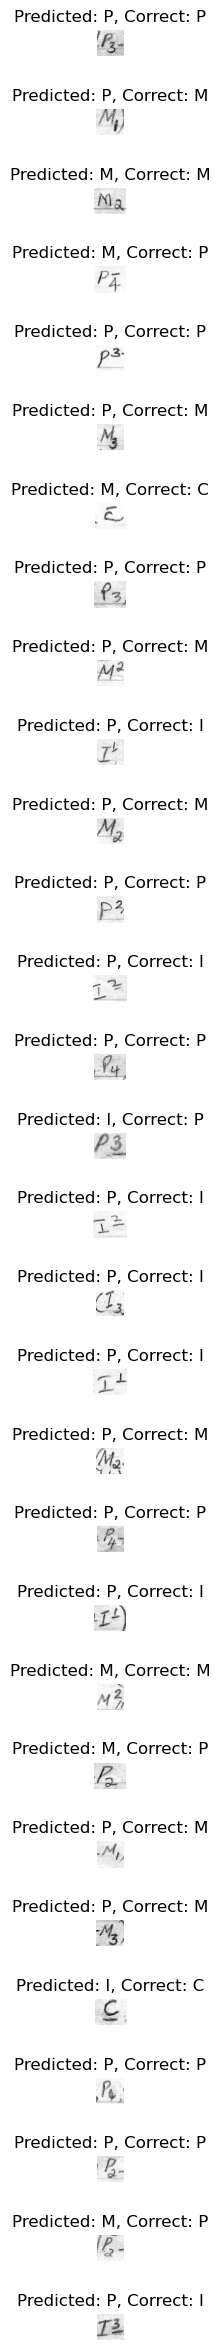

In [41]:
def id_to_tooth(id):
    if id == 0:
        return 'M'
    elif id == 1:
        return 'P'
    elif id == 2:
        return 'C'
    elif id == 3:
        return 'I'

correct = 0
fig, ax = plt.subplots(30, figsize = (500,30))
plt.subplots_adjust(hspace=2)
for i, filename in enumerate(original_images):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    img_num = filename.split('/')[7].split('.')[0]
    loc = int(img_num)
    label = type_labels.iloc[loc]

    preprocessed = preprocess_img(image)
    pred = model.predict(preprocessed.reshape(1,28,28,1))
    pred_tooth = id_to_tooth(np.argmax(pred))
    correct_tooth = id_to_tooth(np.argmax(label))
    fig_title = f'Predicted: {pred_tooth}, Correct: {correct_tooth}'
    if pred_tooth == correct_tooth:
        correct += 1
    
    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(fig_title)

acc = correct/30
print(f"Accuracy: {acc} %")

In [ ]:
%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db
mlflow.set_experiment("MPIC")

params = {
    'data_v': 3,
    'train_size':27,
    'test_size':3,
}

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("training accuracy", acc)
    mlflow.log_metric("test accuracy", test_acc)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("info", "MNIST transferred to MPIC, fit last layer")